In [ ]:
!pip install sentence_transformers datasets lancedb sf-hamilton -qU

# NER Powered Semantic Search

This notebook shows how to use Named Entity Recognition (NER) for vector search with LanceDB & Hamilton. We will:

1. Extract named entities from text.
2. Store them in a LanceDB as metadata (alongside respective text vectors).
3. We extract named entities from incoming queries and use them to filter and search only through records containing these named entities.

This is particularly helpful if you want to restrict the search score to records that contain information about the named entities that are also found within the query.

Let's get started.

In [4]:
%load_ext hamilton.plugins.jupyter_magic

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


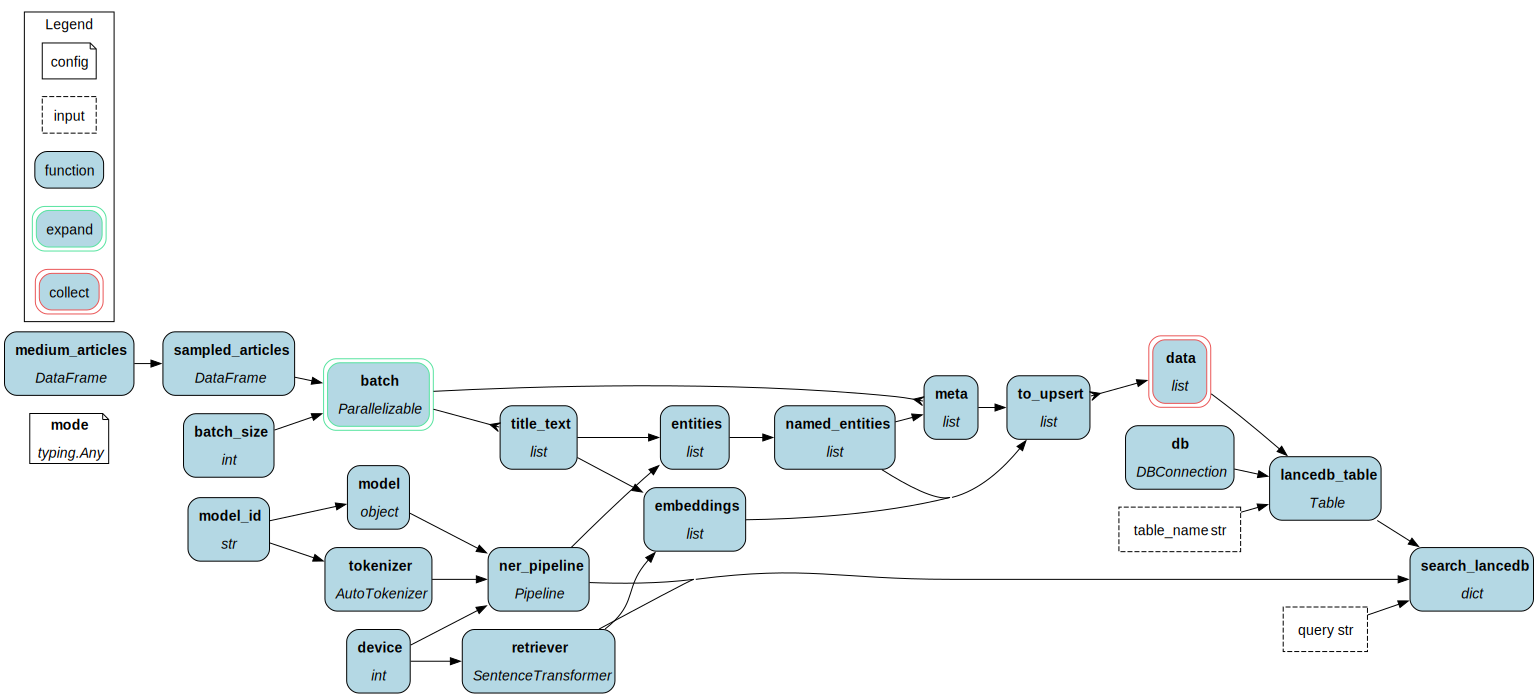

In [37]:
%%cell_to_module -m ner_search --display --config '{"mode":"ingestion"}'
import lancedb
from datasets import load_dataset
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from transformers.pipelines import base
from hamilton.htypes import Parallelizable, Collect
from hamilton.function_modifiers import config
import numpy as np

def medium_articles() -> pd.DataFrame:
    # load the dataset and convert to pandas dataframe
    df = load_dataset(
        "fabiochiu/medium-articles", data_files="medium_articles.csv", split="train"
    ).to_pandas()
    return df

def sampled_articles(medium_articles: pd.DataFrame) -> pd.DataFrame:
    df = medium_articles.dropna().sample(20000, random_state=32)
    # select first 1000 characters
    df["text"] = df["text"].str[:1000]
    # join article title and the text
    df["title_text"] = df["title"] + ". " + df["text"]
    return df

def device() -> int:
    return torch.cuda.current_device() if torch.cuda.is_available() else None


def model_id() -> str:
    # To extract named entities, we will use a NER model finetuned on a BERT-base model.
    # The model can be loaded from the HuggingFace model hub
    return "dslim/bert-base-NER"

def tokenizer(model_id: str) -> AutoTokenizer:
    """load the tokenizer from huggingface"""
    print("Loading the tokenizer")
    return AutoTokenizer.from_pretrained(model_id)

def model(model_id: str) -> object:
    """load the NER model from huggingface"""
    print("Loading the model")
    return  AutoModelForTokenClassification.from_pretrained(model_id)

# load the tokenizer and model into a NER pipeline
def ner_pipeline(model: object, tokenizer: AutoTokenizer, device: int) -> base.Pipeline:
    print("Loading the ner_pipeline")
    return pipeline(
        "ner", model=model, tokenizer=tokenizer, aggregation_strategy="max", device=device
    )

def retriever(device: int) -> SentenceTransformer:
    """A retriever model is used to embed passages (article title + first 1000 characters) and queries. It creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:
    """
    print("Loading the retriever model")
    return SentenceTransformer(
    "flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device
    )


def db() -> lancedb.DBConnection:
    return lancedb.connect("./.lancedb")

def batch_size() -> int:
    # we will use batches of 64
    return 64

def batch(sampled_articles: pd.DataFrame, batch_size: int) -> Parallelizable[pd.DataFrame]:
    # split the articles into batches
    for i in range(0, len(sampled_articles), batch_size):
        # find end of batch
        i_end = min(i + batch_size, len(sampled_articles))
        # extract batch
        batch = sampled_articles.iloc[i:i_end].copy()
        yield batch

def title_text(batch: pd.DataFrame) -> list[str]:
    return batch["title_text"].tolist()

def embeddings(title_text: list[str], retriever: SentenceTransformer) -> list[list[float]]:
    # generate embeddings for batch
    return retriever.encode(title_text).tolist()

def entities(title_text: list[str], ner_pipeline: base.Pipeline) -> list[list[str]]:
    # extract named entities using the NER pipeline
    extracted_batch = ner_pipeline(title_text)
    entities = []
    # loop through the results and only select the entity names
    for text in extracted_batch:
        ne = [entity["word"] for entity in text]
        entities.append(ne)
    return entities

def named_entities(entities: list[list[str]]) -> list[list[str]]:
    return [list(set(entity)) for entity in entities]

def meta(batch: pd.DataFrame, named_entities: list[list[str]]) -> list[dict]:
    # create a dataframe we want for metadata
    df = batch.drop("title_text", axis=1)
    df["named_entities"] = named_entities
    return df.to_dict(orient="records")

def to_upsert(embeddings: list[list[float]],
              meta: list[dict],
              named_entities: list[list[str]]) -> list[tuple[list[float], dict, list[str]]]:
    return list(zip(embeddings, meta, named_entities))

def data(to_upsert: Collect[list[tuple[list[float], dict, list[str]]]]) -> list[dict]:
    data = []
    for result in to_upsert:
        for emb, meta, entity in result:
            temp = dict()
            temp["vector"] = np.array(emb)
            temp["metadata"] = meta
            temp["named_entities"] = entity
            data.append(temp)
    return data

@config.when(mode="ingestion")
def lancedb_table__ingestion(db: lancedb.DBConnection, data: list[dict], table_name: str = "tw") -> lancedb.table.Table:
    tbl = db.create_table(table_name, data)
    return tbl

@config.when(mode="query")
def lancedb_table__query(db: lancedb.DBConnection, table_name: str = "tw") -> lancedb.table.Table:
    tbl = db.open_table(table_name)
    return tbl

def search_lancedb(query: str,
                   ner_pipeline: base.Pipeline,
                   retriever: SentenceTransformer,
                   lancedb_table: lancedb.table.Table) -> dict:
    # extract named entities from the query
    ne = entities([query], ner_pipeline)[0]  # Note: we're directly calling the function here.
    # create embeddings for the query
    xq = retriever.encode(query).tolist()
    # query the lancedb table while applying named entity filter
    xc = lancedb_table.search(xq).to_list()
    # extract article titles from the search result
    r = [
        x["metadata"]["title"]
        for x in xc
        for i in x["metadata"]["named_entities"]
        if i in ne
    ]
    return {"Extracted Named Entities": ne, "Result": r}

In [35]:
from hamilton import driver
dr = (
    driver.Builder()
    .with_config({"mode": "ingestion"})
    .with_modules(ner_search)
    .enable_dynamic_execution(allow_experimental_mode=True)
    .build()
)
results = dr.execute(["retriever", "ner_pipeline", "data", "lancedb_table"])



Graph execution:   0%|          | 0/19 [00:00<?, ?funcs/s]

Graph execution -> medium_articles :   0%|          | 0/19 [00:00<?, ?funcs/s]

Graph execution -> medium_articles :   5%|▌         | 1/19 [00:10<03:16, 10.93s/funcs]

Graph execution -> batch_size      :   5%|▌         | 1/19 [00:10<03:16, 10.93s/funcs]

Graph execution -> db              :  11%|█         | 2/19 [00:10<03:05, 10.93s/funcs]

Graph execution -> sampled_articles:  16%|█▌        | 3/19 [00:10<02:54, 10.93s/funcs]

Graph execution -> sampled_articles:  21%|██        | 4/19 [00:11<00:34,  2.30s/funcs]

Graph execution -> batch           :  21%|██        | 4/19 [00:11<00:34,  2.30s/funcs]

Graph execution -> Execution Complete!:  26%|██▋       | 5/19 [23:49<00:32,  2.30s/funcs]

Graph execution -> Execution Complete!:  26%|██▋       | 5/19 [23:49<1:06:43, 285.96s/funcs]

KeyboardInterrupt



In [ ]:
dr.execute(["search_lancedb"], 
           inputs={"query": "How Data is changing the world?"},
           overrides=results)


In [40]:
dr_inference_only = (
    driver.Builder()
    .with_config({"mode": "query"})
    .with_modules(ner_search)
    .build()
)
dr_inference_only.execute(["search_lancedb"], 
           inputs={"query": "How Data is changing the world?", "table_name": "temp1"},
                          )

Loading the model


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading the tokenizer
Loading the ner_pipeline
Loading the retriever model


{'search_lancedb': {'Extracted Named Entities': ['Data'],
  'Result': ['How the Data Stole Christmas',
   'Top Modern Data Science, Data Engineering, Machine Learning Tasks to Learn in 2021']}}

In [42]:
dr_inference_only.execute(["search_lancedb"], 
           inputs={"query": "How Data is changing the world?", "table_name": "temp1"},
                          )

Loading the model


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading the tokenizer
Loading the ner_pipeline
Loading the retriever model


{'search_lancedb': {'Extracted Named Entities': ['Hamilton'], 'Result': []}}